<a href="https://colab.research.google.com/github/JheanmarcoOscanoa/Laboratorio-16/blob/main/Laboratorio_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SEMANA 16: DESARROLLO DE APLICACIONES DE MACHINE LEARNING

Tomando la información disponible en el repositorio UCI Machine Learning https://archive.ics.uci.edu/ml/datasets/Adult, uniendo los archivos ‘adult.data’ y ‘adult.test’, cuya variable de clasificación tiene las categorías ‘>50K’ y ‘<=50K’, haga lo siguiente:

##  A: Preprocesamiento de la Información

### a.1. Carga y unión de archivos

In [3]:
import pandas as pd
import numpy as np

# Columnas estándar del dataset Adult
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Carga de archivos
a_data = pd.read_csv('/content/drive/MyDrive/Ciclo 05/Mineria de Datos/Semana 16/adult.data', header=None, names=column_names, skipinitialspace=True)
a_test = pd.read_csv('/content/drive/MyDrive/Ciclo 05/Mineria de Datos/Semana 16/adult.test', header=None, names=column_names, skipinitialspace=True, skiprows=1)

# Unión de datasets
df = pd.concat([a_data, a_test], axis=0).reset_index(drop=True)


### a.2. Revisión y corrección de valores faltantes representados como '?']

In [4]:
# Verificar cuántos '?' hay
for col in df.columns:
    print(f"{col}: {df[col].isin(['?']).sum()} valores '?'")

# Reemplazar '?' por NaN
df.replace('?', np.nan, inplace=True)

# Imputar con la moda
for col in ['workclass', 'occupation', 'native-country']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Confirmar que no hay valores nulos
df.isnull().sum().sum()


age: 0 valores '?'
workclass: 2799 valores '?'
fnlwgt: 0 valores '?'
education: 0 valores '?'
education-num: 0 valores '?'
marital-status: 0 valores '?'
occupation: 2809 valores '?'
relationship: 0 valores '?'
race: 0 valores '?'
sex: 0 valores '?'
capital-gain: 0 valores '?'
capital-loss: 0 valores '?'
hours-per-week: 0 valores '?'
native-country: 857 valores '?'
income: 0 valores '?'


np.int64(0)

### a.3. Tratamiento de outliers (univariado y multivariado)

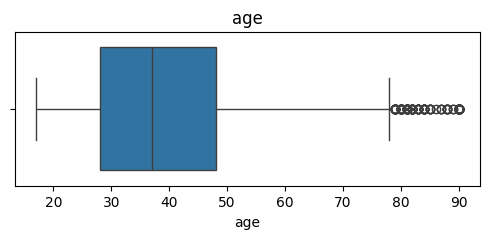

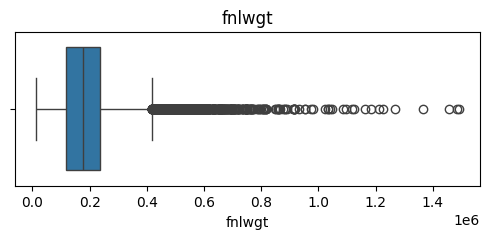

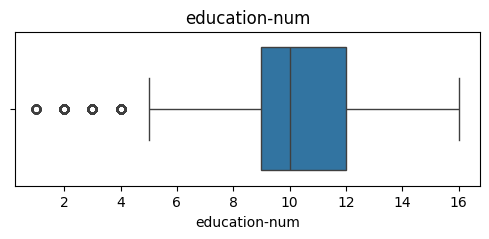

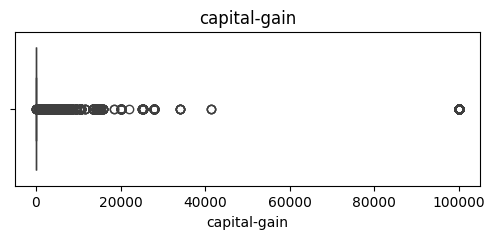

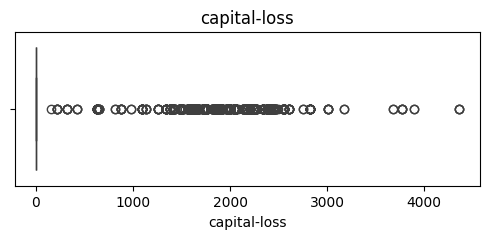

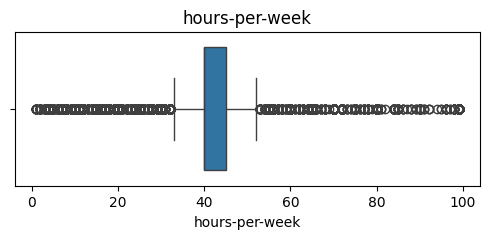

In [5]:
# Visualizar outliers
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
for col in num_cols:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[col])
    plt.title(f'{col}')
    plt.show()

# Aplicar IQR para tratar outliers
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lim_inf, upper=lim_sup)

### a.4. Transformación de la variable objetivo

In [6]:
# Convertir income a binaria
df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

### a.5. Análisis de correlación


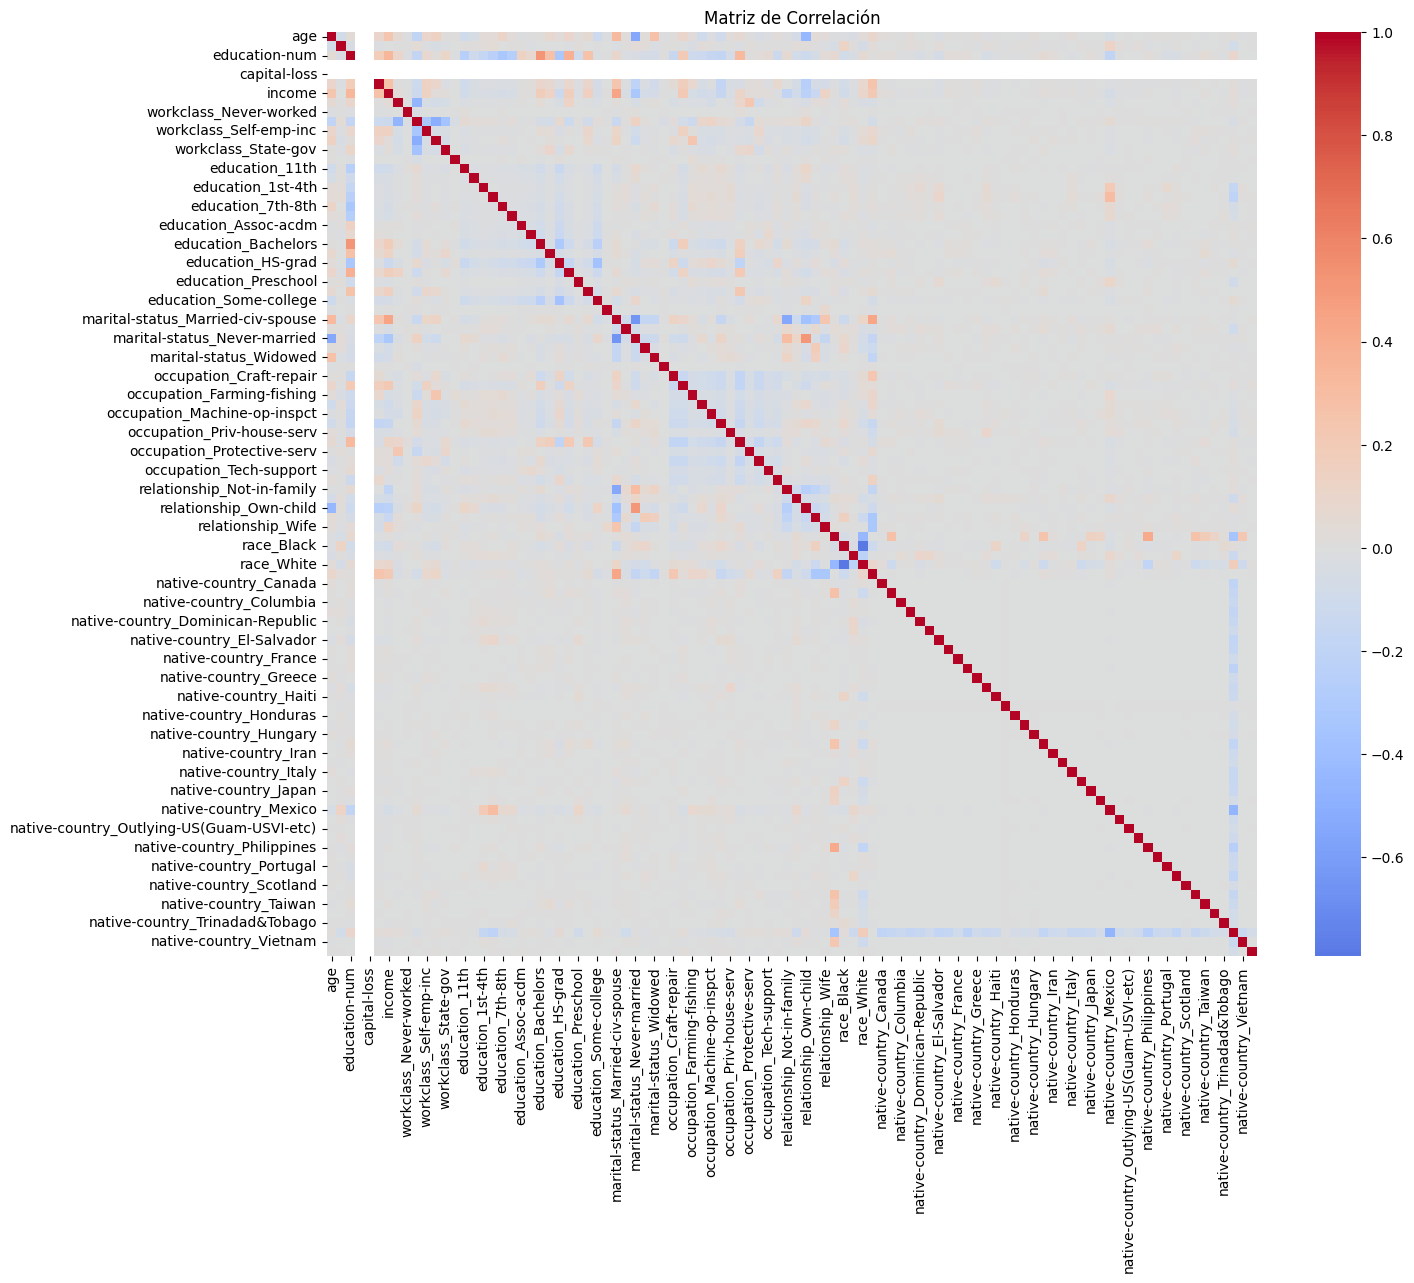

In [8]:
# Matriz de correlación
df_encoded_corr = pd.get_dummies(df, drop_first=True)
plt.figure(figsize=(15, 12))
sns.heatmap(df_encoded_corr.corr(), cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

## b. Selección de variables, escalamiento y preparación del modelo

### b.1. Cálculo del Information Value (IV)

In [9]:
!pip install feature-engine

from feature_engine.encoding import WoEEncoder
from feature_engine.selection import SelectByInformationValue

# Variables categóricas
X = df.drop('income', axis=1)
y = df['income']
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Eliminar variables problemáticas
cat_cols = [col for col in cat_cols if col not in ['workclass', 'native-country']]

# Calcular WOE e IV
woe_encoder = WoEEncoder(variables=cat_cols)
X_woe = woe_encoder.fit_transform(X, y)

selector = SelectByInformationValue(variables=cat_cols, threshold=0.02)
selector.fit(X_woe, y)

# Mostrar IV
iv_summary = pd.DataFrame(selector.information_values_.items(), columns=['Variable', 'IV'])
iv_summary.sort_values(by='IV', ascending=False)

,Variable,IV
3,relationship,1.522003
1,marital-status,1.344593
0,education,0.680379
2,occupation,0.566842
5,sex,0.300521
4,race,0.067633


### b.2. Escalamiento de variables numéricas

In [10]:
from sklearn.preprocessing import StandardScaler

num_cols = df.select_dtypes(include=['int64', 'float64']).drop('income', axis=1).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

### b.3. Conversión de variables categóricas a dummies

In [11]:
df_encoded = pd.get_dummies(df, drop_first=True)

### b.4. División del dataset: entrenamiento y prueba

In [12]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

### b.5. Revisión de balanceo de clases

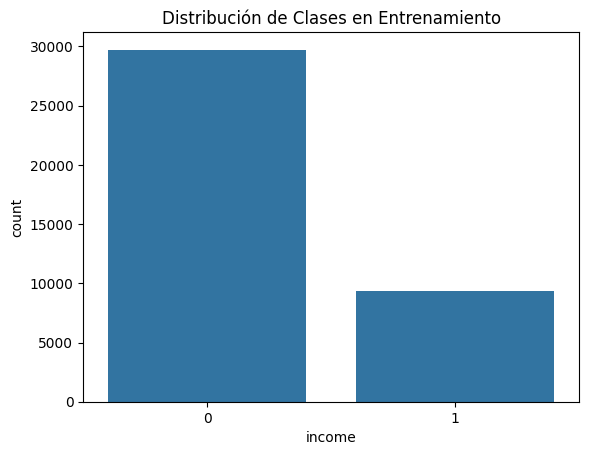

,proportion
income,
0,0.76073
1,0.23927


In [13]:
sns.countplot(x=y_train)
plt.title('Distribución de Clases en Entrenamiento')
plt.show()

y_train.value_counts(normalize=True)

## c. Entrenamiento y comparación de modelos

### c.1. Entrenamiento con hiperparámetros estándar

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

modelos = {
    "LogReg": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "RandomForest": RandomForestClassifier()
}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{nombre} Accuracy: {acc:.4f}")


LogReg Accuracy: 0.8374
KNN Accuracy: 0.8142
DecisionTree Accuracy: 0.7761
SVM Accuracy: 0.8402
RandomForest Accuracy: 0.8252


### c.2. Búsqueda de hiperparámetros (GridSearchCV)

In [15]:
from sklearn.model_selection import GridSearchCV

param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid=param_rf, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Mejor Accuracy:", grid.best_score_)
print("Mejores Hiperparámetros:", grid.best_params_)

Mejor Accuracy: 0.8294474818480404
Mejores Hiperparámetros: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


### c.3. Búsqueda aleatoria (RandomizedSearchCV)

In [16]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_rf, n_iter=5, cv=5)
random_search.fit(X_train, y_train)

print("Mejor Accuracy (Random):", random_search.best_score_)
print("Mejores Hiperparámetros (Random):", random_search.best_params_)

Mejor Accuracy (Random): 0.8290379834020044
Mejores Hiperparámetros (Random): {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10}
